In [5]:
from collections import defaultdict, Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from data_loaders import get_bibliometrics_data
from data_helpers import assign_industries
from plot_helpers import index_subplots

sns.set_theme(context="paper", style="ticks", font="Arial", font_scale=1.0)

In [8]:
df_bio = get_bibliometrics_data("biology")
df_chem = get_bibliometrics_data("chemistry")

df_bio = assign_industries(df_bio, False)
df_chem = assign_industries(df_chem, False)

Authors 82506
Authors 48139
Authors 82506
Authors 48139


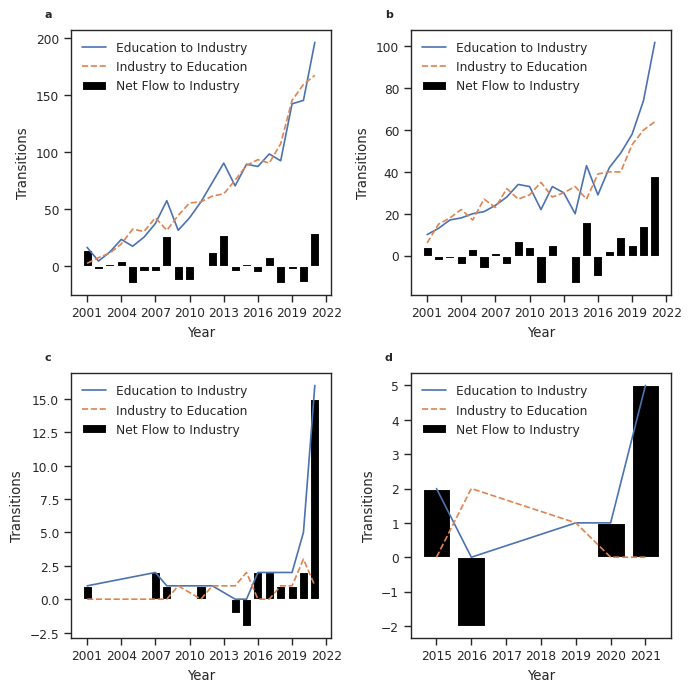

In [14]:
fig, axs = plt.subplots(2, 2, facecolor="white", figsize=(2.0 * 3.5039, 2.0 * 3.5039))

def create_set(x):
    return list(set(x))

def most_common(X):
    return max(set(X), key=X.count)


def get_transitions(df, industry=None):
    df = df.groupby(["author", "year"]).agg({
        "type": create_set,
    }).reset_index()

    df["type"] = df["type"].apply(most_common)


    authors = defaultdict(list)
    for _, row in df.sort_values(["author", "year"]).iterrows():
        authors[row["author"]].append((row["year"], row["type"]))

    print("Authors", len(authors))
    transitions = []
    for author, year_aff in authors.items():
        prev_aff = None
        
        for year, aff in year_aff:
            if prev_aff != None:
                if industry:
                    if aff == industry and prev_aff == "None":
                        transitions.append({"type": "Education to Industry", "year": year})
                    if aff == "None" and prev_aff == industry:
                        transitions.append({"type": "Industry to Education", "year": year})
                else:
                    if aff != "None" and prev_aff == "None":
                        transitions.append({"type": "Education to Industry", "year": year})
                    if aff == "None" and prev_aff != "None":
                        transitions.append({"type": "Industry to Education", "year": year})
            prev_aff = aff

    df_transitions = pd.DataFrame(transitions).groupby(["type", "year"], as_index=False).size()
    df_transitions = df_transitions[(df_transitions.year >= 2001) & (df_transitions.year < 2022)]
    df_transitions = df_transitions.pivot_table(values="size", index="year", columns="type").reset_index().fillna(0)
    df_transitions["diff"] = df_transitions["Education to Industry"] - df_transitions["Industry to Education"]

    return df_transitions.sort_values("year")

df_transitions_bio = get_transitions(df_bio)
df_transitions_chem = get_transitions(df_chem)

df_transitions_bio_tech = get_transitions(df_bio, "Tech")
df_transitions_chem_tech = get_transitions(df_chem, "Tech")


for i, df in enumerate([df_transitions_bio, df_transitions_chem, df_transitions_bio_tech, df_transitions_chem_tech]):
    ax = axs.flat[i]
    ax.bar(df["year"], df["diff"], color="black", label="Net Flow to Industry")
    for l, s in zip(["Education to Industry", "Industry to Education"], ["solid", "dashed"]):
        ax.plot(df["year"], df[l], label=l, linestyle=s)

    ax.legend(frameon=False, loc="upper left")
    ax.set_xlabel("Year")
    ax.set_ylabel("Transitions")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))



index_subplots(axs.flat, font_size=8, y=1.05)
plt.tight_layout()
plt.savefig("transitions.svg")
plt.savefig("transitions.eps")